In [ ]:
# Esentialls
import pandas as pd
import numpy as np

#Building blocks of NN
from tensorflow import keras
from keras import layers
from keras import regularizers

# Tools for working with data and preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split


pd.set_option('max_rows', 162)

In [ ]:
# Normalization of numerical variables and encoding of categorical variables
numeric_features = ['atCAx','atCAy','atCAz','atNx','atNy','atNz','distC(i)_N(i+3)','C(i-3)','C(i+3)']
categorical_features = ['aa']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
label_transformer = OneHotEncoder(sparse = False)

preprocessor = ColumnTransformer(transformers=[
        ("numerical", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

preprocessor_labels = ColumnTransformer(transformers=[
        ("label", label_transformer, ['n/t'])
    ]
)

In [ ]:
# Division of data into  training and validaion sets 
data = pd.read_csv('dataset_N_CA_with_distance_2.csv')

data = data[data['distC(i)_N(i+3)'] < 25]
x_pred = pd.DataFrame(data.iloc[:162,~data.columns.isin(['n/t'])])
df = pd.DataFrame(data.iloc[163:50904,:])

x_train, x_valid, y_train, y_valid = train_test_split(df.loc[:,['aa','atCAx','atCAy','atCAz','atNx','atNy','atNz','distC(i)_N(i+3)','C(i-3)','C(i+3)']],df.loc[:,['n/t']],stratify=df.loc[:,'n/t'],train_size = 0.7)

x_train = preprocessor.fit_transform(x_train)
x_valid = preprocessor.transform(x_valid)

y_train = preprocessor_labels.fit_transform(y_train)
y_valid = preprocessor_labels.transform(y_valid)

input_shape = [x_train.shape[1]]


In [ ]:
# labels enbcoded using one hot encoding + sigmoid in output layer

# Defining topology of the neural network
model = keras.Sequential([
                          layers.Dense(units = 256, activation = 'relu',input_shape = input_shape),
                          layers.BatchNormalization(),
                          layers.Dropout(0.3),
                          layers.Dense(units = 1024, activation = 'relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(0.3),
                          layers.Dense(units = 1024, activation = 'relu'), 
                          layers.BatchNormalization(),
                          layers.Dropout(0.3),
                          layers.Dense(units = 256, activation = 'relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(0.3),
                          layers.Dense(units = 2, activation = 'sigmoid')
                          ])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
model.compile(optimizer = 'Adam',loss='CategoricalCrossentropy',metrics=['accuracy','Recall','Precision'])


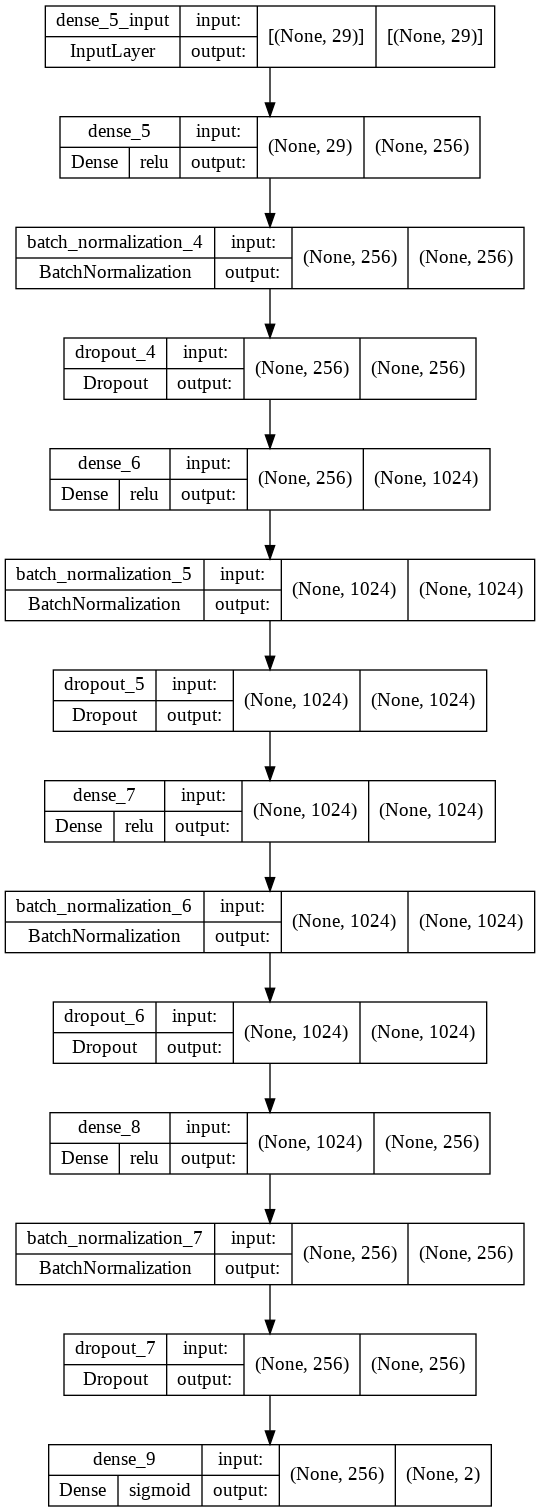

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations = True )

In [ ]:
#512
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=76, 
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
461/461 [==============================] - 21s 41ms/step - loss: 0.5983 - accuracy: 0.7150 - recall: 0.5663 - precision: 0.6539 - val_loss: 0.5141 - val_accuracy: 0.7533 - val_recall: 0.4649 - val_precision: 0.7397
Epoch 2/100
461/461 [==============================] - 19s 41ms/step - loss: 0.4968 - accuracy: 0.7544 - recall: 0.5857 - precision: 0.6995 - val_loss: 0.4756 - val_accuracy: 0.7587 - val_recall: 0.5880 - val_precision: 0.6968
Epoch 3/100
461/461 [==============================] - 19s 41ms/step - loss: 0.4793 - accuracy: 0.7616 - recall: 0.5679 - precision: 0.7089 - val_loss: 0.4647 - val_accuracy: 0.7704 - val_recall: 0.6322 - val_precision: 0.7671
Epoch 4/100
461/461 [==============================] - 19s 41ms/step - loss: 0.4729 - accuracy: 0.7670 - recall: 0.5787 - precision: 0.7434 - val_loss: 0.4588 - val_accuracy: 0.7731 - val_recall: 0.5960 - val_precision: 0.8122
Epoch 5/100
461/461 [==============================] - 19s 41ms/step - loss: 0.4670 - accura

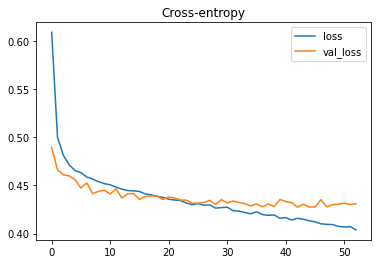

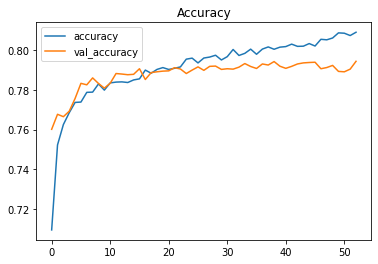

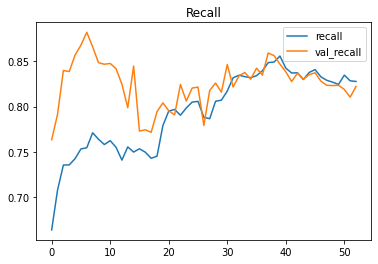

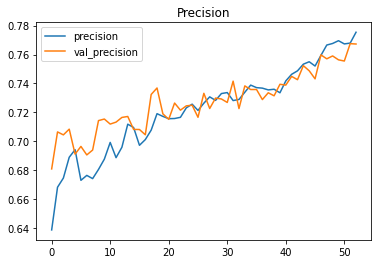

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")
history_df.loc[:, ['recall', 'val_recall']].plot(title="Recall")
history_df.loc[:, ['precision', 'val_precision']].plot(title="Precision")